<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/submit_moving35_dense2_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [248]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [249]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [250]:
import os  # osモジュールをインポート
import tensorflow as tf
import numpy as np
import random

# シードを固定
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

# 決定論的な動作を確保するための設定
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # TensorFlowで決定論的な動作を保証
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # cuDNNで決定論的な動作を保証

In [251]:
df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/sample_submit.csv", header=None)

In [252]:
# 事前に作成した特徴量データをインポート
merged_df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/merged_df_2.csv")
df = merged_df.copy()

In [253]:
pd.set_option('display.max_columns', None)
df[:1917].describe()
# 2011-01-01 ~ 2016-03-31

,y,client,price_am,price_pm,trend,seasonal,residual,y_bc_1_2,client_mean,price_am_mean,price_pm_mean,is_train,y_lag_365,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1891.000000,1891.000000,1917.0,1552.000000,1916.000000,1916.000000,1910.000000,1910.000000,1887.000000,1887.000000,1827.000000,1827.000000,1552.000000,1552.000000,1911.000000,1888.000000,1828.000000,1911.000000,1888.000000,1828.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1.917000e+03
mean,35.804903,0.107460,0.769953,0.525300,35.637599,0.249529,-0.082225,9.557925,41.804802,43.927762,44.016278,1.0,33.386598,0.767745,0.523486,0.756021,0.511518,0.745098,0.498145,0.752600,0.504652,0.771263,0.525129,0.766166,0.758651,0.752747,0.521716,0.510876,0.505191,2013.141888,6.308816,15.725613,2.999478,25.718832,2.699531,0.285863,0.032864,0.032864,2.437141,0.010955,0.010955,0.003130,0.002608,1.0,2.514345,3.498174,0.018258,0.010433,0.017214,526612.188445,4.119433,97.772238,101.879874,101.142499,99.264799,3.000000e-01
std,17.262632,0.309777,1.057716,0.914971,9.280903,12.925255,5.035453,3.104678,3.044833,11.447007,11.242253,0.0,16.148330,1.053565,0.911758,1.033819,0.887385,1.027819,0.871288,1.032913,0.876463,1.066396,0.909517,0.775024,0.533381,0.336354,0.684850,0.469456,0.286153,1.520803,3.505973,8.800553,2.000913,15.330926,1.268893,0.451943,0.178327,0.178327,1.136709,0.104117,0.104117,0.055872,0.051018,0.0,1.138356,1.708270,0.133917,0.101634,0.130103,10227.154958,0.513904,1.736938,2.430198,0.678858,0.292215,2.165500e-15
min,0.000000,0.000000,-1.000000,-1.000000,18.100942,-47.954564,-27.424270,-2.000000,40.748571,34.931429,36.864745,1.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.571429,-0.066667,0.266667,-0.571429,-0.100000,0.133333,2011.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,503949.300000,3.400000,95.698650,98.808200,99.387086,98.893476,3.000000e-01
25%,23.000000,0.000000,0.000000,0.000000,27.808185,-7.709907,-3.325194,7.591663,40.748571,34.931429,36.864745,1.0,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.466667,0.544444,0.142857,0.266667,0.322222,2012.000000,3.000000,8.000000,1.000000,12.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.000000,0.000000,0.000000,517290.437363,3.632258,96.275557,99.766675,100.609987,99.091660,3.000000e-01
50%,34.000000,0.000000,0.000000,0.000000,39.861618,-0.911151,-0.201739,9.661904,40.748571,34.931429,36.864745,1.0,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.600000,0.611111,0.285714,0.366667,0.366667,2013.000000,6.000000,16.000000,3.000000,25.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,3.000000,3.000000,0.000000,0.000000,0.000000,527621.807609,4.138710,96.966314,101.591800,101.188638,99.1

In [254]:
pd.set_option('display.max_columns', None)
df[1917:].describe()
# 2016-04-01 ~ 2017-03-31

,y,client,price_am,price_pm,trend,seasonal,residual,y_bc_1_2,client_mean,price_am_mean,price_pm_mean,is_train,y_lag_365,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N
count,0.0,365.000000,365.000000,365.000000,0.0,0.0,0.0,0.0,365.000000,360.000000,360.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,NaN,0.452055,0.794521,0.586301,NaN,NaN,NaN,NaN,45.191863,44.248109,44.868842,0.0,46.087671,0.794521,0.586301,0.800000,0.594521,0.786301,0.572603,0.780822,0.564384,0.764384,0.526027,0.798434,0.795068,0.787245,0.590215,0.583927,0.571385,2016.246575,6.526027,15.720548,3.002740,26.463014,2.698630,0.284932,0.032877,0.032877,2.509589,0.010959,0.010959,0.002740,0.002740,1.0,2.490411,3.515068,0.019178,0.010959,0.016438,544332.606986,3.167945,99.974418,108.485682,102.799637,98.918724,3.000000e-01
std,NaN,0.498379,1.002180,0.958667,NaN,NaN,NaN,NaN,4.898618,10.775812,11.770860,0.0,18.069098,1.002180,0.958667,1.019588,0.986153,1.012737,0.951179,1.008842,0.937229,1.021388,0.939082,0.755868,0.552362,0.343597,0.775468,0.582155,0.354027,0.431609,3.452584,8.808321,2.000685,15.024956,1.269734,0.452001,0.178559,0.178559,1.118300,0.104252,0.104252,0.052342,0.052342,0.0,1.118300,1.712244,0.137339,0.104252,0.127329,2658.157620,0.116446,0.218077,1.382975,0.233800,0.061306,1.834383e-15
min,NaN,0.000000,-1.000000,-1.000000,NaN,NaN,NaN,NaN,40.748571,34.931429,36.864745,0.0,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.571429,0.033333,0.400000,-0.571429,-0.066667,0.244444,2016.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,541020.600000,2.900000,99.669130,106.808900,102.316374,98.794385,3.000000e-01
25%,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,40.748571,34.931429,36.864745,0.0,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.500000,0.577778,0.285714,0.333333,0.333333,2016.000000,4.000000,8.000000,1.000000,13.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,2.000000,0.000000,0.000000,0.000000,542199.100000,3.100000,99.845592,107.402463,102.638977,98.893476,3.000000e-01
50%,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,40.748571,47.388646,36.864745,0.0,44.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.571429,0.633333,0.633333,0.428571,0.400000,0.388889,2016.000000,7.000000,16.000000,3.000000,26.000000,3.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.0,2.000000,4.000000,0.000000,0.000000,0.000000,542884.072826,3.180645,99.928571,107.688462,102.791409,98.893476,3.000000e-01
75%,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,50.577670,47.388646,51.140625,0.0,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,0.955556,0.

# データ処理

In [255]:
# 年度の初日をindex出力
dates = ["2011-04-01", "2012-04-01", "2013-04-01", "2014-04-01", "2015-04-01", "2016-04-01"]

for date in dates:
    print(f"{date}:", df[df["datetime"] == date].index)

2011-04-01: Index([90], dtype='int64')
2012-04-01: Index([456], dtype='int64')
2013-04-01: Index([821], dtype='int64')
2014-04-01: Index([1186], dtype='int64')
2015-04-01: Index([1551], dtype='int64')
2016-04-01: Index([1917], dtype='int64')


In [256]:
# 別で時系列を作成するので削除
df.drop(['seasonal', 'trend', 'residual', 'y_bc_1_2', 'y_lag_365', 'is_train'], axis=1, inplace=True)

# 欠損値は一旦０に
df = df.fillna(0)

In [257]:
# 時系列の分解したデータも予測しないと行けない
# from statsmodels.tsa.seasonal import STL
# import matplotlib.pyplot as plt

# # STL関数を使って時系列分解
# # 期間は頻度mに等しい：日時データを使うので期間はm=365とする
# decomposition = STL(df["y"], period=365).fit()

# # # 分解結果のプロット
# # fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10, 8))

# # # datetimeカラムを取得
# # datetime_col = df["datetime"]

# # 各分解値をカラムに追加
# df['trend'] = decomposition.trend
# df['seasonal'] = decomposition.seasonal
# df['residual'] = decomposition.resid

In [258]:
# タイムステップ(秒単位)に変更
df['datetime'] = pd.to_datetime(df['datetime'])
df['timestamp_s'] = df['datetime'].apply(lambda x: x.timestamp())
df = df.drop(['datetime'], axis=1)

In [259]:
# 指標データの特徴量を作成
economic_cols = ['JPNRGDPEXP', 'LRUN64TTJPM156S', 'JPNCPIALLMINMEI', 'QJPN628BIS', 'LCEAPR03JPM661S', 'JPNCPIHOUMINMEI', 'IRSTCB01JPM156N']

lags = [1, 7, 30, 90, 365]
for col in economic_cols:
    for lag in lags:
        # ラグ特徴量
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)
        # 差分特徴量
        df[f"{col}_diff_{lag}"] = df[col].shift(lag) - df[col]

# # Prophet予測データの特徴量を作成
# forecast_cols = ['trend', 'holidays', 'monthly', 'multiplicative_terms', 'season_forecast', 'weekly', 'yearly', 'additive_terms']

# lags = [1, 7, 30, 90, 365]
# for col in forecast_cols:
#     for lag in lags:
#         # ラグ特徴量
#         df[f"{col}_lag_{lag}"] = df[col].shift(lag)
#         # 差分特徴量
#         df[f"{col}_diff_{lag}"] = df[col].shift(lag) - df[col]

df = df.fillna(0)

In [260]:
# MinMaxScalerでスケーリング
from sklearn.preprocessing import MinMaxScaler

# 特徴量用のスケーラー
scaler_features = MinMaxScaler(feature_range=(0, 1))

# ターゲット変数用のスケーラー
scaler_target = MinMaxScaler(feature_range=(0, 1))

# 元のデータフレームの列名
feature_columns = df.drop(columns=['y']).columns
target_column = ['y']

# 特徴量とターゲット変数を分けてスケーリング
input_features_scaled = scaler_features.fit_transform(df.drop(columns=['y']))  # 特徴量のスケーリング
target_values_scaled = scaler_target.fit_transform(df[['y']])  # 目的変数 'y' のスケーリング

# スケーリングされた特徴量と目的変数を元のデータフレームに戻す
scaled_df = pd.DataFrame(input_features_scaled, columns=feature_columns)  # 特徴量をデータフレームに戻す
scaled_df['y'] = target_values_scaled  # 目的変数 'y' を追加

In [261]:
train_df = scaled_df[:1917] # 2011-01-01 ~ 2016-03-31
test_df = scaled_df[456:] # 2012-04-01 ~ 2017-03-31

In [262]:
pd.set_option('display.max_columns', None)
print(train_df.shape)
train_df.describe()

(1917, 121)


,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s,JPNRGDPEXP_lag_1,JPNRGDPEXP_diff_1,JPNRGDPEXP_lag_7,JPNRGDPEXP_diff_7,JPNRGDPEXP_lag_30,JPNRGDPEXP_diff_30,JPNRGDPEXP_lag_90,JPNRGDPEXP_diff_90,JPNRGDPEXP_lag_365,JPNRGDPEXP_diff_365,LRUN64TTJPM156S_lag_1,LRUN64TTJPM156S_diff_1,LRUN64TTJPM156S_lag_7,LRUN64TTJPM156S_diff_7,LRUN64TTJPM156S_lag_30,LRUN64TTJPM156S_diff_30,LRUN64TTJPM156S_lag_90,LRUN64TTJPM156S_diff_90,LRUN64TTJPM156S_lag_365,LRUN64TTJPM156S_diff_365,JPNCPIALLMINMEI_lag_1,JPNCPIALLMINMEI_diff_1,JPNCPIALLMINMEI_lag_7,JPNCPIALLMINMEI_diff_7,JPNCPIALLMINMEI_lag_30,JPNCPIALLMINMEI_diff_30,JPNCPIALLMINMEI_lag_90,JPNCPIALLMINMEI_diff_90,JPNCPIALLMINMEI_lag_365,JPNCPIALLMINMEI_diff_365,QJPN628BIS_lag_1,QJPN628BIS_diff_1,QJPN628BIS_lag_7,QJPN628BIS_diff_7,QJPN628BIS_lag_30,QJPN628BIS_diff_30,QJPN628BIS_lag_90,QJPN628BIS_diff_90,QJPN628BIS_lag_365,QJPN628BIS_diff_365,LCEAPR03JPM661S_lag_1,LCEAPR03JPM661S_diff_1,LCEAPR03JPM661S_lag_7,LCEAPR03JPM661S_diff_7,LCEAPR03JPM661S_lag_30,LCEAPR03JPM661S_diff_30,LCEAPR03JPM661S_lag_90,LCEAPR03JPM661S_diff_90,LCEAPR03JPM661S_lag_365,LCEAPR03JPM661S_diff_365,JPNCPIHOUMINMEI_lag_1,JPNCPIHOUMINMEI_diff_1,JPNCPIHOUMINMEI_lag_7,JPNCPIHOUMINMEI_diff_7,JPNCPIHOUMINMEI_lag_30,JPNCPIHOUMINMEI_diff_30,JPNCPIHOUMINMEI_lag_90,JPNCPIHOUMINMEI_diff_90,JPNCPIHOUMINMEI_lag_365,JPNCPIHOUMINMEI_diff_365,IRSTCB01JPM156N_lag_1,IRSTCB01JPM156N_diff_1,IRSTCB01JPM156N_lag_7,IRSTCB01JPM156N_diff_7,IRSTCB01JPM156N_lag_30,IRSTCB01JPM156N_diff_30,IRSTCB01JPM156N_lag_90,IRSTCB01JPM156N_diff_90,IRSTCB01JPM156N_lag_365,IRSTCB01JPM156N_diff_365,y
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.0,1917.000000,1917.0,1917.000000,1917.0,1917.000000,1917.0,1917.000000,1917.0,1917.000000
mean,0.107460,0.294992,0.254217,0.107460,0.476758,0.480656,0.294557,0.253869,0.292210,0.251608,0.288906,0.248392,0.286211,0.246827,0.270736,0.237524,0.252605,0.271280,0.458170,0.206502,0.218005,0.377011,0.356981,0.482620,0.490854,0.499913,0.475362,0.424883,0.285863,0.032864,0.032864,0.479047,0.010955,0.010955,0.003130,0.002608,0.0,0.504782,0.499635,0.018258,0.0

In [263]:
pd.set_option('display.max_columns', None)
print(test_df.shape)
test_df.describe()

(1826, 121)


,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s,JPNRGDPEXP_lag_1,JPNRGDPEXP_diff_1,JPNRGDPEXP_lag_7,JPNRGDPEXP_diff_7,JPNRGDPEXP_lag_30,JPNRGDPEXP_diff_30,JPNRGDPEXP_lag_90,JPNRGDPEXP_diff_90,JPNRGDPEXP_lag_365,JPNRGDPEXP_diff_365,LRUN64TTJPM156S_lag_1,LRUN64TTJPM156S_diff_1,LRUN64TTJPM156S_lag_7,LRUN64TTJPM156S_diff_7,LRUN64TTJPM156S_lag_30,LRUN64TTJPM156S_diff_30,LRUN64TTJPM156S_lag_90,LRUN64TTJPM156S_diff_90,LRUN64TTJPM156S_lag_365,LRUN64TTJPM156S_diff_365,JPNCPIALLMINMEI_lag_1,JPNCPIALLMINMEI_diff_1,JPNCPIALLMINMEI_lag_7,JPNCPIALLMINMEI_diff_7,JPNCPIALLMINMEI_lag_30,JPNCPIALLMINMEI_diff_30,JPNCPIALLMINMEI_lag_90,JPNCPIALLMINMEI_diff_90,JPNCPIALLMINMEI_lag_365,JPNCPIALLMINMEI_diff_365,QJPN628BIS_lag_1,QJPN628BIS_diff_1,QJPN628BIS_lag_7,QJPN628BIS_diff_7,QJPN628BIS_lag_30,QJPN628BIS_diff_30,QJPN628BIS_lag_90,QJPN628BIS_diff_90,QJPN628BIS_lag_365,QJPN628BIS_diff_365,LCEAPR03JPM661S_lag_1,LCEAPR03JPM661S_diff_1,LCEAPR03JPM661S_lag_7,LCEAPR03JPM661S_diff_7,LCEAPR03JPM661S_lag_30,LCEAPR03JPM661S_diff_30,LCEAPR03JPM661S_lag_90,LCEAPR03JPM661S_diff_90,LCEAPR03JPM661S_lag_365,LCEAPR03JPM661S_diff_365,JPNCPIHOUMINMEI_lag_1,JPNCPIHOUMINMEI_diff_1,JPNCPIHOUMINMEI_lag_7,JPNCPIHOUMINMEI_diff_7,JPNCPIHOUMINMEI_lag_30,JPNCPIHOUMINMEI_diff_30,JPNCPIHOUMINMEI_lag_90,JPNCPIHOUMINMEI_diff_90,JPNCPIHOUMINMEI_lag_365,JPNCPIHOUMINMEI_diff_365,IRSTCB01JPM156N_lag_1,IRSTCB01JPM156N_diff_1,IRSTCB01JPM156N_lag_7,IRSTCB01JPM156N_diff_7,IRSTCB01JPM156N_lag_30,IRSTCB01JPM156N_diff_30,IRSTCB01JPM156N_lag_90,IRSTCB01JPM156N_diff_90,IRSTCB01JPM156N_lag_365,IRSTCB01JPM156N_diff_365,y
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.0,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.0,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.0,1826.0,1826.0,1826.0,1826.0,1826.0,1826.0,1826.0,1826.0,1826.0,1826.000000
mean,0.203176,0.294085,0.254472,0.203176,0.476252,0.481100,0.294085,0.254564,0.293629,0.254016,0.292990,0.252464,0.292716,0.252099,0.291895,0.251460,0.252642,0.276074,0.483644,0.207706,0.224158,0.402929,0.541256,0.502141,0.490927,0.499817,0.492480,0.424973,0.285323,0.032859,0.032859,0.502921,0.010953,0.010953,0.002738,0.002738,0.0,0.497079,0.499890,0.019168,0.010953,0.016429,0.645994,0

In [264]:
test_df = test_df.drop(['y'], axis=1)

In [265]:
test_df.tail()

,client,price_am,price_pm,client_mean,price_am_mean,price_pm_mean,price_am_lag_1,price_pm_lag_1,price_am_lag_7,price_pm_lag_7,price_am_lag_30,price_pm_lag_30,price_am_lag_90,price_pm_lag_90,price_am_lag_365,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_am_moving_avg_90,price_pm_moving_avg_7,price_pm_moving_avg_30,price_pm_moving_avg_90,year,month,day,day_of_week,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,season,rokuyo,golden_week,obon,new_year,JPNRGDPEXP,LRUN64TTJPM156S,JPNCPIALLMINMEI,QJPN628BIS,LCEAPR03JPM661S,JPNCPIHOUMINMEI,IRSTCB01JPM156N,timestamp_s,JPNRGDPEXP_lag_1,JPNRGDPEXP_diff_1,JPNRGDPEXP_lag_7,JPNRGDPEXP_diff_7,JPNRGDPEXP_lag_30,JPNRGDPEXP_diff_30,JPNRGDPEXP_lag_90,JPNRGDPEXP_diff_90,JPNRGDPEXP_lag_365,JPNRGDPEXP_diff_365,LRUN64TTJPM156S_lag_1,LRUN64TTJPM156S_diff_1,LRUN64TTJPM156S_lag_7,LRUN64TTJPM156S_diff_7,LRUN64TTJPM156S_lag_30,LRUN64TTJPM156S_diff_30,LRUN64TTJPM156S_lag_90,LRUN64TTJPM156S_diff_90,LRUN64TTJPM156S_lag_365,LRUN64TTJPM156S_diff_365,JPNCPIALLMINMEI_lag_1,JPNCPIALLMINMEI_diff_1,JPNCPIALLMINMEI_lag_7,JPNCPIALLMINMEI_diff_7,JPNCPIALLMINMEI_lag_30,JPNCPIALLMINMEI_diff_30,JPNCPIALLMINMEI_lag_90,JPNCPIALLMINMEI_diff_90,JPNCPIALLMINMEI_lag_365,JPNCPIALLMINMEI_diff_365,QJPN628BIS_lag_1,QJPN628BIS_diff_1,QJPN628BIS_lag_7,QJPN628BIS_diff_7,QJPN628BIS_lag_30,QJPN628BIS_diff_30,QJPN628BIS_lag_90,QJPN628BIS_diff_90,QJPN628BIS_lag_365,QJPN628BIS_diff_365,LCEAPR03JPM661S_lag_1,LCEAPR03JPM661S_diff_1,LCEAPR03JPM661S_lag_7,LCEAPR03JPM661S_diff_7,LCEAPR03JPM661S_lag_30,LCEAPR03JPM661S_diff_30,LCEAPR03JPM661S_lag_90,LCEAPR03JPM661S_diff_90,LCEAPR03JPM661S_lag_365,LCEAPR03JPM661S_diff_365,JPNCPIHOUMINMEI_lag_1,JPNCPIHOUMINMEI_diff_1,JPNCPIHOUMINMEI_lag_7,JPNCPIHOUMINMEI_diff_7,JPNCPIHOUMINMEI_lag_30,JPNCPIHOUMINMEI_diff_30,JPNCPIHOUMINMEI_lag_90,JPNCPIHOUMINMEI_diff_90,JPNCPIHOUMINMEI_lag_365,JPNCPIHOUMINMEI_diff_365,IRSTCB01JPM156N_lag_1,IRSTCB01JPM156N_diff_1,IRSTCB01JPM156N_lag_7,IRSTCB01JPM156N_diff_7,IRSTCB01JPM156N_lag_30,IRSTCB01JPM156N_diff_30,IRSTCB01JPM156N_lag_90,IRSTCB01JPM156N_diff_90,IRSTCB01JPM156N_lag_365,IRSTCB01JPM156N_diff_365
2277,0.0,1.000000,0.833333,0.0,1.000000,0.971798,0.833333,0.833333,0.666667,0.833333,0.666667,0.666667,0.166667,0.166667,1.000000,0.833333,0.837838,0.744444,0.645390,0.864865,0.819277,0.686957,1.0,0.181818,0.866667,0.000000,0.230769,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.997904,0.038123,0.943722,0.926748,0.979716,0.090909,0.0,0.998246,0.999827,0.455436,0.999827,0.455436,0.999827,0.455436,0.999660,0.450200,0.998374,0.382773,0.584440,0.333333,0.580645,0.333333,0.574230,0.404762,0.611006,0.560815,0.666667,0.643725,0.997189,0.615374,0.996405,0.615374,0.993921,0.635889,0.995261,0.649529,0.993594,0.711872,0.992140,0.906798,0.992702,0.906798,0.994854,0.906798,0.998417,0.856420,0.999565,0.333851,0.999230,0.30306,0.998731,0.30306,0.995607,0.348704,0.999574,0.488488,0.996734,0.347858,0.990079,0.643678,0.990079,0.643678,0.989938,0.610675,0.990079,0.602649,0.992063,0.571429,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2278,0.0,0.833333,0.833333,0.0,0.867726,0.971798,1.000000,0.833333,0.833333,0.833333,0.500000,0.500000,0.166667,0.166667,0.833333,0.833333,0.837838,0.766667,0.673759,0.864865,0.843373,0.721739,1.0,0.181818,0.900000,0.166667,0.230769,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.998428,0.039589,0.946468,0.925886,0.984787,0.090909,0.0,0.998685,0.999870,0.455436,0.999870,0.455436,0.999870,0.455436,0.999745,0.451247,0.998355,0.381230,0.585073,0.333333,0.581278,0.333333,0.572829,0.386905,0.610373,0.553974,0.666667,0.639676,0.997320,0.615374,0.996536,0.615374,0.993921,0.630760,0.995196,0.644284,0.993659,0.710405,0.992047,0.906798,0.992608,0.906798,0.994760,0.906798,0.998813,0.866496,0.999674,0.337778,0.999422,0.30306,0.998924,0.30306,0.995473,0.337293,0.999680,0.485136,0.996608,0.340213,0.990079,0.643678,0.990079,0.643678,0.98

In [266]:
# import matplotlib.pyplot as plt

# # val_df と test_df の特徴量の分布をヒストグラムで確認
# for col in df.drop(columns=['y']).columns:
#     plt.figure(figsize=(10, 5))
#     plt.hist(df[821:1917][col], bins=30, alpha=0.5, label='val_df')
#     plt.hist(df[1917:][col], bins=30, alpha=0.5, label='test_df')
#     plt.title(f'Feature: {col}')
#     plt.legend()
#     plt.show()


# LSTMモデル

In [285]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber  # Huber損失関数をインポート
import tensorflow as tf
import numpy as np

# LSTMモデルを定義
def create_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(1, activation='linear')  # 出力層。予測する値が1つの場合
    ])
    return model

# 'y'列を除いたデータを使う
input_features = train_df.drop(columns=['y']).values  # 特徴量のみ
input_shape = (365, input_features.shape[1])  # 日分のデータと、特徴量の数
model = create_model(input_shape)

# モデルのコンパイルと訓練
def compile_and_fit(model, input_features, target_values, patience=3, max_epochs=50):
    # EarlyStoppingコールバックを定義
    early_stopping = EarlyStopping(monitor='loss', patience=patience, mode='min', restore_best_weights=True)

    # モデルをコンパイル
    optimizer = Adam(learning_rate=0.01)  # デフォルトの学習率は0.001なので、少し下げる
    model.compile(loss=Huber(), optimizer=optimizer, metrics=[MeanAbsoluteError()])

    # データをウィンドウに分割（日分のデータを持つウィンドウを作成）
    input_data = []
    target_data = []

    for i in range(len(input_features) - 365):  # 日分のウィンドウを作成
        input_data.append(input_features[i:i + 365])  # 特徴量のみ
        target_data.append(target_values[i + 365])  # 'y'列のターゲット値

    input_data = np.array(input_data)
    target_data = np.array(target_data)

    # モデルの訓練実行
    history = model.fit(input_data, target_data, batch_size=16, epochs=max_epochs, callbacks=[early_stopping], verbose=1)

    return history, input_data  # input_dataも返す

# 'y'列をターゲット値として取得
target_values = train_df['y'].values

# トレーニング実行
history, input_data = compile_and_fit(model, input_features, target_values)  # 特徴量とターゲット値を渡す


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step - loss: 0.0975 - mean_absolute_error: 0.2682
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 276ms/step - loss: 0.0108 - mean_absolute_error: 0.1119
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - loss: 0.0092 - mean_absolute_error: 0.1044
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - loss: 0.0057 - mean_absolute_error: 0.0836
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - loss: 0.0044 - mean_absolute_error: 0.0738
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - loss: 0.0038 - mean_absolute_error: 0.0683
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - loss: 0.0035 - mean_absolute_error: 0.0649
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 255ms/step - loss: 0.0033 - mean_absolute_error: 0.0631
Epoch 9/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 231ms/step - loss: 0.0032 - mean_absolute_error: 0.0619
Epoch 10/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - loss: 0.0031 - mean_absolute_error: 0.0610
Epoch 11/50
97/97 ━

In [286]:
# test_dfで予測を行う関数（自己回帰）
def predict_test_data(model, test_df, window_size=365):
    test_input_features = test_df  # 'y'列を除いた特徴量のみ
    test_input_data = []

    # test_dfをウィンドウに分割（日分のデータを使用）
    for i in range(len(test_input_features) - window_size):
        test_input_data.append(test_input_features[i:i + window_size])  # 日分のデータを使用

    test_input_data = np.array(test_input_data)

    # 予測を実行
    test_predictions_scaled = model.predict(test_input_data)

    return test_predictions_scaled

# test_dfで予測を実行（window_size、未来の365日を予測）
test_predictions_scaled = predict_test_data(model, test_df, window_size=365)

# 予測値を逆スケーリングして元のスケールに戻す
test_predictions = scaler_target.inverse_transform(test_predictions_scaled)

# 予測結果を出力
print("Test data predictions:", test_predictions)

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step
Test data predictions: [[47.727196]
 [51.528633]
 [57.003258]
 ...
 [94.32377 ]
 [96.03788 ]
 [95.11775 ]]


In [287]:
# target_true_valuesをPandasのSeriesに変換
target_true_values = pd.Series(scaler_target.inverse_transform(target_values.reshape(-1, 1)).flatten())
# インデックスをリセット
target_true_values = target_true_values.reset_index(drop=True)

# 821行に0を追加する（test_predictionsに合わせて次元を調整）
zeros_to_add = np.zeros((1186-365, test_predictions.shape[1]))  # 821行と同じ列数のゼロを作成
# test_predictionsの先頭に0を追加
test_predictions_padded = np.concatenate([zeros_to_add, test_predictions], axis=0)
# numpy配列をPandasのDataFrameに変換してインデックスをリセット
test_predictions_padded_df = pd.DataFrame(test_predictions_padded).reset_index(drop=True)

In [288]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# target_true_values と test_predictions_padded_df の長さを確認
target_true_len = len(target_true_values)
test_predictions_len = len(test_predictions_padded_df)

# データの長さを一致させるための処理
max_len = max(target_true_len, test_predictions_len)

# target_true_values に足りない分は 0 を追加
if target_true_len < max_len:
    target_true_values = pd.Series(np.concatenate([target_true_values.values, np.zeros(max_len - target_true_len)]))

# test_predictions_padded_df の 1 列目に足りない分は 0 を追加
if test_predictions_len < max_len:
    test_predictions_padded_df[0] = pd.Series(np.concatenate([test_predictions_padded_df[0].values, np.zeros(max_len - test_predictions_len)]))

# 1917日分のdate_rangeを作成
start_date = datetime(2011, 1, 1)
date_range = [start_date + timedelta(days=i) for i in range(max_len)]  # max_len 日数の範囲

# DataFrameの作成
valid_df = pd.DataFrame({
    'date': date_range,                       # 1列目: 2011年1月1日からの日付
    'target_true_values': target_true_values, # 2列目: 実際の値
    'test_predictions': test_predictions_padded_df[0],  # 3列目: 予測値
    'diff_values': target_true_values - test_predictions_padded_df[0]  # 4列目: 実際の値と予測値の差
})

# 結果を確認
pd.set_option('display.max_rows', None)
valid_df

,date,target_true_values,test_predictions,diff_values
0,2011-01-01,0.0,0.000000,0.000000
1,2011-01-02,0.0,0.000000,0.000000
2,2011-01-03,0.0,0.000000,0.000000
3,2011-01-04,16.0,0.000000,16.000000
4,2011-01-05,16.0,0.000000,16.000000
5,2011-01-06,13.0,0.000000,13.000000
6,2011-01-07,14.0,0.000000,14.000000
7,2011-01-08,16.0,0.000000,16.000000
8,2011-01-09,16.0,0.000000,16.000000
9,2011-01-10,14.0,0.000000,14.000000


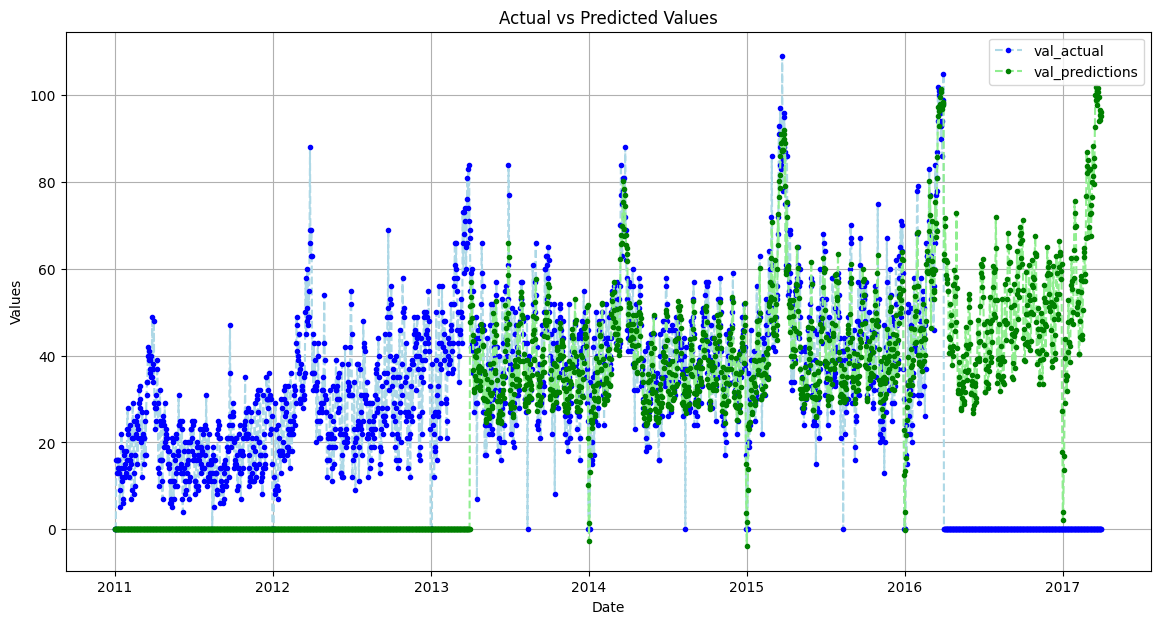

In [289]:
# グラフのサイズを設定
plt.figure(figsize=(14, 7))

# 実際の値（target_true_values）のプロット
plt.plot(valid_df['date'], valid_df['target_true_values'], ls='--', color='lightblue', label='val_actual', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue')

# 予測値（test_predictions_padded_df）のプロット
plt.plot(valid_df['date'], valid_df['test_predictions'], ls='--', color='lightgreen', label='val_predictions', marker='o', markersize=3, markerfacecolor='green', markeredgecolor='green')

# グラフのタイトルとラベル
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')

plt.legend()  # 凡例を表示
plt.grid(True)  # グリッドを表示
plt.show()  # グラフを表示


In [290]:
# 評価範囲
val_actual1 = valid_df['target_true_values'][1186:1551].values  # 2015年度(365日)
val_actual2 = valid_df['target_true_values'][1551:1917].values  # 2016年度(366日)

val_predictions1 = valid_df['test_predictions'][1186:1551].values  # 予測値をnumpy配列に変換
val_predictions2 = valid_df['test_predictions'][1551:1917].values

# MAEの計算
mae = tf.keras.metrics.MeanAbsoluteError()
val_performance1 = mae(val_actual1, val_predictions1).numpy()
val_performance2 = mae(val_actual2, val_predictions2).numpy()

print(f"Validation MAE 2015: {val_performance1}")
print(f"Validation MAE 2016: {val_performance2}")

Validation MAE 2015: 5.1012187004089355
Validation MAE 2016: 5.738430023193359


In [291]:
# インデックスをリセットして連番にする
submit_test_df = valid_df['test_predictions'][-365:].reset_index(drop=True)

# 休業日の実績を0にする
submit_test_df.iloc[137] = 0
submit_test_df.iloc[274] = 0
submit_test_df.iloc[275] = 0
submit_test_df.iloc[276] = 0
submit_test_df.iloc[277] = 0

# DataFrameを作成
df_submit1 = pd.DataFrame({
    'datetime': sample_submit.iloc[:, 0].reset_index(drop=True),  # datetime列
    'y': submit_test_df.reset_index(drop=True)  # 1次元のsubmit_test_dfをそのまま使用
})

In [303]:
# CSVとして保存
df_submit1.to_csv("submit_moving35_dense2_hub.csv", index=False, header=False)
df_submit1

,datetime,y
0,2016-04-01,63.335247
1,2016-04-02,61.968052
2,2016-04-03,71.762634
3,2016-04-04,69.843643
4,2016-04-05,62.141747
5,2016-04-06,58.582947
6,2016-04-07,57.568806
7,2016-04-08,56.689770
8,2016-04-09,61.506420
9,2016-04-10,54.778484


# 自己回帰LSTM

In [293]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import MeanAbsoluteError
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.losses import Huber  # Huber損失関数をインポート
# import tensorflow as tf

# # 自己回帰LSTMモデルを定義
# def create_model(input_shape):
#     model = Sequential([
#         LSTM(64, return_sequences=True, input_shape=input_shape),  # 最初のLSTM層
#         LSTM(32, return_sequences=False),  # 2つ目のLSTM層
#         Dense(1, activation='relu')  # 出力層
#     ])
#     return model

# # 'y'列を除いたデータを使う
# input_features = train_df.drop(columns=['y']).values  # 特徴量のみ
# input_shape = (365, input_features.shape[1])  # 365日分のデータと、特徴量の数
# model = create_model(input_shape)

# # 自己回帰による予測関数
# def predict_autoregressive(model, initial_input, steps=365):
#     predictions = []
#     current_input = initial_input.copy()

#     for _ in range(steps):
#         # 現在の入力から1つ予測
#         pred = model.predict(current_input[np.newaxis, :, :])
#         predictions.append(pred[0, 0])  # 1つの値を追加

#         # 自己回帰: 新しい予測値を使って次の入力を作成
#         current_input = np.roll(current_input, shift=-1, axis=0)  # 過去を1つずらす
#         current_input[-1, -1] = pred  # 新しい予測値を追加

#     return np.array(predictions)

# # モデルのコンパイルと訓練
# def compile_and_fit(model, input_features, target_values, patience=3, max_epochs=50):
#     # EarlyStoppingコールバックを定義
#     early_stopping = EarlyStopping(monitor='loss', patience=patience, mode='min', restore_best_weights=True)

#     # モデルをコンパイル
#     model.compile(loss=Huber(), optimizer=Adam(), metrics=[MeanAbsoluteError()])

#     # データをウィンドウに分割（365日分のデータを持つウィンドウを作成）
#     input_data = []
#     target_data = []

#     for i in range(len(input_features) - 365):
#         input_data.append(input_features[i:i + 365])  # 特徴量のみ
#         target_data.append(target_values[i + 365])  # 'y'列のターゲット値

#     input_data = np.array(input_data)
#     target_data = np.array(target_data)

#     # モデルの訓練実行
#     history = model.fit(input_data, target_data, epochs=max_epochs, callbacks=[early_stopping], verbose=1)

#     return history, input_data  # input_dataも返す

# # 'y'列をターゲット値として取得
# target_values = train_df['y'].values

# # トレーニング実行
# history, input_data = compile_and_fit(model, input_features, target_values)  # 特徴量とターゲット値を渡す

# # 自己回帰による予測
# initial_input = input_features[-365:]  # 最後の365日分を最初の入力に
# predictions = predict_autoregressive(model, initial_input, steps=365)

# # 結果を確認
# print(predictions)


In [294]:
# # test_dfで自己回帰LSTMを使って予測を行う関数
# def predict_test_data(model, test_df, window_size=365, steps=365):
#     # 最初の365日分のデータを入力として使用
#     test_input_features = test_df[-window_size:].values  # 'y'列を除いた特徴量のみ
#     predictions = []

#     # 自己回帰的に予測を行う
#     for _ in range(steps):
#         # 現在の入力で予測
#         pred = model.predict(test_input_features[np.newaxis, :, :])  # 1つの予測を実行
#         predictions.append(pred[0, 0])  # 予測値をリストに追加

#         # 自己回帰: 新しい予測を次の入力にフィードバック
#         test_input_features = np.roll(test_input_features, shift=-1, axis=0)  # 過去データを1つシフト
#         test_input_features[-1, -1] = pred  # 予測値を最後の特徴量として使用

#     return np.array(predictions)

# # test_dfで予測を実行
# test_predictions_scaled = predict_test_data(model, test_df, window_size=365, steps=365)

# # 目的変数 'y' だけを逆変換して元のスケールに戻す
# test_predictions = scaler_target.inverse_transform(test_predictions_scaled.reshape(-1, 1))

# # 予測結果を出力
# print("Test data predictions:", test_predictions)


In [295]:
# # test_dfで自己回帰LSTMを使って予測を行う関数
# def predict_test_data(model, test_df, window_size=365, total_steps=730, future_steps=365):
#     # 最初の365日分のデータを入力として使用
#     test_input_features = test_df[-window_size:].values  # 'y'列を除いた特徴量のみ
#     predictions = []

#     # 自己回帰的に予測を行う (2年分)
#     for _ in range(total_steps):  # 残りの2年分 (730日)
#         # 現在の入力で予測
#         pred = model.predict(test_input_features[np.newaxis, :, :])  # 1つの予測を実行
#         predictions.append(pred[0, 0])  # 予測値をリストに追加

#         # 自己回帰: 新しい予測を次の入力にフィードバック
#         test_input_features = np.roll(test_input_features, shift=-1, axis=0)  # 過去データを1つシフト
#         test_input_features[-1, -1] = pred  # 予測値を最後の特徴量として使用

#     # さらに未来1年分を予測
#     for _ in range(future_steps):  # 未来365日分
#         pred = model.predict(test_input_features[np.newaxis, :, :])  # 1つの予測を実行
#         predictions.append(pred[0, 0])  # 予測値をリストに追加

#         # 自己回帰: 新しい予測を次の入力にフィードバック
#         test_input_features = np.roll(test_input_features, shift=-1, axis=0)  # 過去データを1つシフト
#         test_input_features[-1, -1] = pred  # 予測値を最後の特徴量として使用

#     return np.array(predictions)

# # test_dfで予測を実行
# # 2年分 (730日) の予測と、さらに1年分の未来予測を実行
# test_predictions_scaled = predict_test_data(model, test_df, window_size=365, total_steps=730, future_steps=365)

# # 目的変数 'y' だけを逆変換して元のスケールに戻す
# test_predictions = scaler_target.inverse_transform(test_predictions_scaled.reshape(-1, 1))

# # 予測結果を出力
# print("Test data predictions:", test_predictions)


In [296]:
# # target_true_valuesをPandasのSeriesに変換
# target_true_values = pd.Series(scaler_target.inverse_transform(target_values.reshape(-1, 1)).flatten())
# # インデックスをリセット
# target_true_values = target_true_values.reset_index(drop=True)

# # 821行に0を追加する（test_predictionsに合わせて次元を調整）
# zeros_to_add = np.zeros((1186, test_predictions.shape[1]))  # 821行と同じ列数のゼロを作成
# # test_predictionsの先頭に0を追加
# test_predictions_padded = np.concatenate([zeros_to_add, test_predictions], axis=0)
# # numpy配列をPandasのDataFrameに変換してインデックスをリセット
# test_predictions_padded_df = pd.DataFrame(test_predictions_padded).reset_index(drop=True)

In [297]:
# import pandas as pd
# import numpy as np
# from datetime import datetime, timedelta

# # target_true_values と test_predictions_padded_df の長さを確認
# target_true_len = len(target_true_values)
# test_predictions_len = len(test_predictions_padded_df)

# # データの長さを一致させるための処理
# max_len = max(target_true_len, test_predictions_len)

# # target_true_values に足りない分は 0 を追加
# if target_true_len < max_len:
#     target_true_values = pd.Series(np.concatenate([target_true_values.values, np.zeros(max_len - target_true_len)]))

# # test_predictions_padded_df の 1 列目に足りない分は 0 を追加
# if test_predictions_len < max_len:
#     test_predictions_padded_df[0] = pd.Series(np.concatenate([test_predictions_padded_df[0].values, np.zeros(max_len - test_predictions_len)]))

# # 1917日分のdate_rangeを作成
# start_date = datetime(2011, 1, 1)
# date_range = [start_date + timedelta(days=i) for i in range(max_len)]  # max_len 日数の範囲

# # DataFrameの作成
# valid_df2 = pd.DataFrame({
#     'date': date_range,                       # 1列目: 2011年1月1日からの日付
#     'target_true_values': target_true_values, # 2列目: 実際の値
#     'test_predictions': test_predictions_padded_df[0],  # 3列目: 予測値
#     'diff_values': target_true_values - test_predictions_padded_df[0]  # 4列目: 実際の値と予測値の差
# })

# # 結果を確認
# pd.set_option('display.max_rows', None)
# valid_df

In [298]:
# # グラフのサイズを設定
# plt.figure(figsize=(14, 7))

# # 実際の値（target_true_values）のプロット
# plt.plot(valid_df2['date'], valid_df2['target_true_values'], ls='--', color='lightblue', label='val_actual', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue')

# # 予測値（test_predictions_padded_df）のプロット
# plt.plot(valid_df2['date'], valid_df2['test_predictions'], ls='--', color='lightgreen', label='val_predictions', marker='o', markersize=3, markerfacecolor='green', markeredgecolor='green')

# # グラフのタイトルとラベル
# plt.title('Actual vs Predicted Values')
# plt.xlabel('Date')
# plt.ylabel('Values')

# plt.legend()  # 凡例を表示
# plt.grid(True)  # グリッドを表示
# plt.show()  # グラフを表示


In [299]:
# # 評価範囲
# val_actual1 = valid_df['target_true_values'][1186:1551].values  # 2015年度(365日)
# val_actual2 = valid_df['target_true_values'][1551:1917].values  # 2016年度(366日)

# val_predictions1 = valid_df['test_predictions'][1186:1551].values  # 予測値をnumpy配列に変換
# val_predictions2 = valid_df['test_predictions'][1551:1917].values

# # MAEの計算
# mae = tf.keras.metrics.MeanAbsoluteError()
# val_performance1 = mae(val_actual1, val_predictions1).numpy()
# val_performance2 = mae(val_actual2, val_predictions2).numpy()

# print(f"Validation MAE 2015: {val_performance1}")
# print(f"Validation MAE 2016: {val_performance2}")

In [300]:
# # インデックスをリセットして連番にする
# submit_test_df2 = valid_df2['test_predictions'][-365:].reset_index(drop=True)

# # 休業日の実績を0にする
# submit_test_df2.iloc[137] = 0
# submit_test_df2.iloc[274] = 0
# submit_test_df2.iloc[275] = 0
# submit_test_df2.iloc[276] = 0
# submit_test_df2.iloc[277] = 0

# # DataFrameを作成
# df_submit2 = pd.DataFrame({
#     'datetime': sample_submit.iloc[:, 0].reset_index(drop=True),  # datetime列
#     'y': submit_test_df2.reset_index(drop=True)  # 1次元のsubmit_test_dfをそのまま使用
# })

In [301]:
# # CSVとして保存
# df_submit2.to_csv("submit_moving33.csv", index=False, header=False)
# df_submit2